In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve

from tqdm.notebook import tqdm

np.random.seed(42)

# Helper function

In [31]:
def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    #r_train = recall_score(y_train, y_hat_train)
    #r_test = recall_score(y_test, y_hat_test)

    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

scores = pd.DataFrame(columns = ['f1_train', 'f1_test', 'accuracy_train', 
                                    'accuracy_test', 'roc_auc', 'pr_auc', 
                                    'model', 'vectorizer'])

def scoreTable(model, model_name, vectorizer, y_train, y_hat_train, y_test, y_hat_test):
    
    
    # storing scores
    f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = \
    return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    # list of scores
    score_list = []
    score_list.extend((f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc, 
                       str(model), str(vectorizer)))
    
    # adding scores to score table
    scores.loc[model_name] = score_list
    return scores

def model_eval(model, model_name, vectorizer, X_train, X_test, y_train, y_test, column):
    
    X_train_vectorized = vectorizer.fit_transform(X_train[column])
    model.fit(X_train_vectorized, y_train)
    
    X_test_vectorized = vectorizer.transform(X_test[column])
    
    y_hat_train = model.predict(X_train_vectorized)
    y_hat_test = model.predict(X_test_vectorized)
    
    col_names = vectorizer.get_feature_names_out()
    
    return scoreTable(model, model_name, vectorizer, y_train, y_hat_train, 
                      y_test, y_hat_test) 

def model_eval_store(model, model_name, vectorizer, X_train, X_test, y_train, y_test, column):
    
    X_train_vectorized = vectorizer.fit_transform(X_train[column])
    model.fit(X_train_vectorized, y_train)
    
    X_test_vectorized = vectorizer.transform(X_test[column])
    
    y_hat_train = model.predict(X_train_vectorized)
    y_hat_test = model.predict(X_test_vectorized)
    
    col_names = vectorizer.get_feature_names_out()
    
    return X_train_vectorized, X_test_vectorized, y_hat_train, y_hat_test, col_names, \
    scoreTable(model, model_name, vectorizer, y_train, y_hat_train, y_test, y_hat_test) 

# Loading data

In [32]:
data = pd.read_csv("preprocessed_tweets2.csv")

C:\Users\Jehoiada Wong\AppData\Local\Temp\ipykernel_8368\2704960313.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("preprocessed_tweets2.csv")


# Splitting the data

In [33]:
X = data.drop(columns='labels')
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Checking the proportion of each class to make sure the data is balanced

In [34]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

labels
0    0.526775
1    0.473225
Name: proportion, dtype: float64
labels
0    0.5281
1    0.4719
Name: proportion, dtype: float64


# Models

### Selecting a baseline model

We are using Logistic Regression as our baseline model with TF-IDF Vectorizer

In [35]:
MAX_FEAT = 450
MAX_ITER = 10000

baseline_model = LogisticRegression(max_iter=MAX_ITER)

vectorizer = TfidfVectorizer(max_features=MAX_FEAT)

vectorized_xtrain = vectorizer.fit_transform(X_train['text_without_stopwords'])
vectorized_xtest = vectorizer.transform(X_test['text_without_stopwords'])

pd.DataFrame.sparse.from_spmatrix(vectorized_xtrain, columns=vectorizer.get_feature_names_out())

,account,ada,address,affiliatemarketing,ago,airdrop,airdropinspector,airdrops,alert,already,...,would,xlm,xom,xrp,year,years,yet,yieldfarming,ªð,ºð
0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.414916,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.424577,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
79996,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
79997,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
79998,0.0,0.24585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.231035,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
baseline_cv = cross_val_score(baseline_model, vectorized_xtrain, y_train)
baseline_cv

array([0.8873125, 0.8861875, 0.89075  , 0.889875 , 0.88675  ])

In [37]:
baseline_model.fit(vectorized_xtrain, y_train)

y_hat_train_baseline = baseline_model.predict(vectorized_xtrain)
y_hat_test_baseline = baseline_model.predict(vectorized_xtest)

scoreTable(baseline_model, 'baseline', vectorizer, y_train, 
                   y_hat_train_baseline, y_test, y_hat_test_baseline)

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.874089,0.871278,0.889262,0.88695,0.882896,0.852678,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)


### Vectorizer Tuning

We will look at how changing the vectorizer affects the performance of the baseline model

In [38]:
models = [
        (LogisticRegression(), 'baseline_tfidf2', TfidfVectorizer(max_features=450), X_train, X_test, y_train, y_test, 'text_without_stopwords'), 
        (LogisticRegression(), 'baseline_tfidf3', TfidfVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_tfidf4', TfidfVectorizer(ngram_range=(2,2)), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_tfidf5', TfidfVectorizer(ngram_range=(2,2)), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_tfidf6', TfidfVectorizer(max_features=5000), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv', CountVectorizer(max_features=5000), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv2', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv3', CountVectorizer(ngram_range=(2,2)), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv4', CountVectorizer(ngram_range=(2,2)), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'tf_1000', TfidfVectorizer(max_features=1000), X_train, X_test, y_train, y_test, 'text_without_stopwords'), 
        (LogisticRegression(), 'tf_5000', TfidfVectorizer(max_features=5000), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'cv_1000', CountVectorizer(max_features=1000), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LogisticRegression(), 'cv_5000', CountVectorizer(max_features=5000), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
]

In [39]:
for run in models:
    model_eval(*run)

display(scores)

c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.874089,0.871278,0.889262,0.88695,0.882896,0.852678,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_tfidf2,0.874089,0.871278,0.889262,0.88695,0.882896,0.852678,LogisticRegression(),TfidfVectorizer(max_features=450)
baseline_tfidf3,0.955728,0.938011,0.958975,0.94310,0.941460,0.921965,LogisticRegression(),TfidfVectorizer()
baseline_tfidf4,0.941011,0.779779,0.946525,0.81660,0.809761,0.766253,LogisticRegression(),"TfidfVectorizer(ngram_range=(2, 2))"
baseline_tfidf5,0.941011,0.779779,0.946525,0.81660,0.809761,0.766253,LogisticRegression(),"TfidfVectorizer(ngram_range=(2, 2))"
baseline_tfidf6,0.954546,0.943382,0.957788,0.94775,0.946403,0.927028,LogisticRegression(),TfidfVectorizer(max_features=5000)
baseline_cv,0.976589,0.965653,0.977975,0.96780,0.967343,0.951778,LogisticRegression(),CountVectorizer(max_features=5000)
baseline_cv2,0.988644,0.966571,0.989275,0.96870,0.968178,0.953719,LogisticRegression(),CountVectorizer()
baseline_cv3,0.995015,0.798033,0.995300,0.83365,0.826349,0.793954,LogisticRegression(),"CountVectorizer(ngram_range=(2, 2))"
baseline_cv4,0.995015,0.798033,0.995300,0.83365,0.826349,0.793954,LogisticRegression(),"CountVectorizer(ngram_range=(2, 2))"


Baseline_cv2 works best so we are going to use the vectorizer at Baseline_cv2

In [40]:
baseline_scores = scores

### Model Tuning

Resetting the score table and leaving the baseline and the most optimal one only

In [41]:
scores = scores.loc[['baseline', 'baseline_cv2']]
scores

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.874089,0.871278,0.889262,0.88695,0.882896,0.852678,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_cv2,0.988644,0.966571,0.989275,0.96870,0.968178,0.953719,LogisticRegression(),CountVectorizer()


In [42]:
models = [
    (MultinomialNB(), 'mnb_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
    (LinearSVC(), 'svc_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
    (RandomForestClassifier(), 'rfc_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
    (XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3), 'xgb_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
    (GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3), 'gbm_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
]

In [43]:
for run in models:
    model_eval(*run)

display(scores)

c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.874089,0.871278,0.889262,0.88695,0.882896,0.852678,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_cv2,0.988644,0.966571,0.989275,0.96870,0.968178,0.953719,LogisticRegression(),CountVectorizer()
mnb_cv,0.902325,0.854182,0.907737,0.86210,0.861770,0.797630,MultinomialNB(),CountVectorizer()
svc_cv,0.999129,0.975801,0.999175,0.97720,0.977038,0.964391,LinearSVC(),CountVectorizer()
rfc_cv,1.000000,0.952566,1.000000,0.95480,0.955170,0.925514,RandomForestClassifier(),CountVectorizer()
xgb_cv,0.821358,0.815703,0.852537,0.84860,0.841225,0.817303,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
gbm_cv,0.825295,0.819577,0.855100,0.85125,0.844050,0.820134,GradientBoostingClassifier(),CountVectorizer()


TOP 2 Models
1. svc_cv
2. baseline_cv2

We are going to hyper tune these 2 models

In [44]:
models = [(LogisticRegression(solver='saga', max_iter=200), 'logreg2', 
         CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
        (LinearSVC(class_weight='balanced'), 'svc2', 
         CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords')]

for run in models:
    model_eval(*run)

display(scores)

c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.874089,0.871278,0.889262,0.88695,0.882896,0.852678,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_cv2,0.988644,0.966571,0.989275,0.96870,0.968178,0.953719,LogisticRegression(),CountVectorizer()
mnb_cv,0.902325,0.854182,0.907737,0.86210,0.861770,0.797630,MultinomialNB(),CountVectorizer()
svc_cv,0.999129,0.975801,0.999175,0.97720,0.977038,0.964391,LinearSVC(),CountVectorizer()
rfc_cv,1.000000,0.952566,1.000000,0.95480,0.955170,0.925514,RandomForestClassifier(),CountVectorizer()
xgb_cv,0.821358,0.815703,0.852537,0.84860,0.841225,0.817303,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
gbm_cv,0.825295,0.819577,0.855100,0.85125,0.844050,0.820134,GradientBoostingClassifier(),CountVectorizer()
logreg2,0.968586,0.953041,0.970588,0.95630,0.955417,0.936920,"LogisticRegression(max_iter=200, solver='saga')",CountVectorizer()
svc2,0.999010,0.975654,0.999062,0.97705,0.976912,0.963952,LinearSVC(class_weight='balanced'),CountVectorizer()


The best performing model is still LinearSVC

Adding the engineered feature is not possible since it is very RAM-Intensive so I will not add it

In [45]:
vec = CountVectorizer()
final_model = LinearSVC()

vec_xtrain = vec.fit_transform(X_train['text_without_stopwords'])
vec_xtest = vec.transform(X_test['text_without_stopwords'])

final_model.fit(vec_xtrain, y_train)

print(final_model.score(vec_xtrain, y_train))
print(final_model.score(vec_xtest, y_test))

y_hat_train_final = final_model.predict(vec_xtrain)
y_hat_test_final = final_model.predict(vec_xtest)

scoreTable(final_model, 'final_feat', vec, y_train, y_hat_train_final, y_test, y_hat_test_final)
display(scores)

c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.999175
0.9772


c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.874089,0.871278,0.889262,0.88695,0.882896,0.852678,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_cv2,0.988644,0.966571,0.989275,0.96870,0.968178,0.953719,LogisticRegression(),CountVectorizer()
mnb_cv,0.902325,0.854182,0.907737,0.86210,0.861770,0.797630,MultinomialNB(),CountVectorizer()
svc_cv,0.999129,0.975801,0.999175,0.97720,0.977038,0.964391,LinearSVC(),CountVectorizer()
rfc_cv,1.000000,0.952566,1.000000,0.95480,0.955170,0.925514,RandomForestClassifier(),CountVectorizer()
xgb_cv,0.821358,0.815703,0.852537,0.84860,0.841225,0.817303,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
gbm_cv,0.825295,0.819577,0.855100,0.85125,0.844050,0.820134,GradientBoostingClassifier(),CountVectorizer()
logreg2,0.968586,0.953041,0.970588,0.95630,0.955417,0.936920,"LogisticRegression(max_iter=200, solver='saga')",CountVectorizer()
svc2,0.999010,0.975654,0.999062,0.97705,0.976912,0.963952,LinearSVC(class_weight='balanced'),CountVectorizer()
final_feat,0.999129,0.975801,0.999175,0.97720,0.977038,0.964391,LinearSVC(),CountVectorizer()


In [50]:
X_train_vec, X_test_vec, y_hat_train, y_hat_test, col_names, score_table  = \
model_eval_store(LinearSVC(), 'svc_cv', 
                 CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords')

c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\anaconda3\envs\natural-language-processing\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Words like "best," "great," and "win" emerge with notably positive coefficients, signifying their strong association with favorable outcomes. Conversely, words such as "insane," "boring," and "worst" exhibit high negative coefficients, indicative of their potent connection to negative sentiments. The absolute coefficients further underscore the overall influence of these words, offering valuable insights into their relative importance. Additionally, nuances are evident, with words like "better" and "interesting" displaying positive coefficients but with varying degrees of impact compared to more strongly associated terms.

In [51]:
coef_df = pd.DataFrame(final_model.coef_, columns=col_names).transpose()

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
insane,-4.085007,4.085007
best,3.809633,3.809633
boring,-3.666603,3.666603
great,3.632865,3.632865
lol,3.542697,3.542697
worst,-3.392980,3.392980
good,3.276822,3.276822
greatest,3.241708,3.241708
win,3.129593,3.129593
secret,-3.083995,3.083995


In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # for label size
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f")

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=45)
    plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)
    plt.tight_layout()
    plt.show()

Normalized confusion matrix


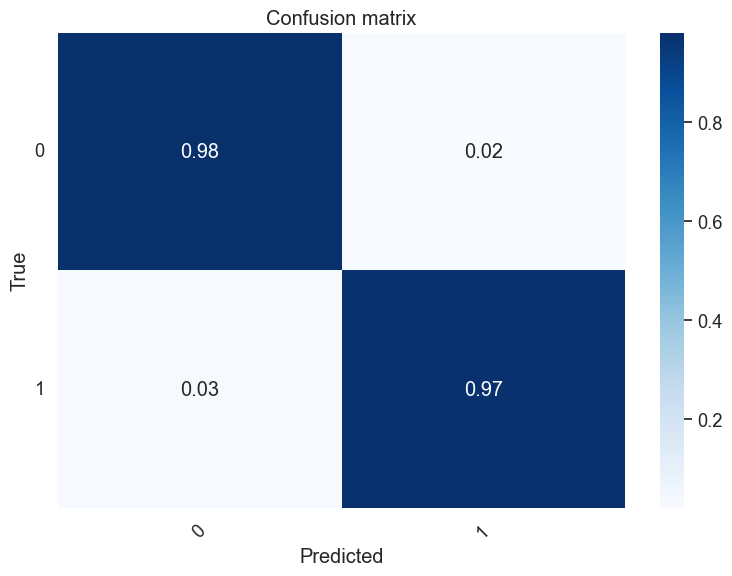

In [64]:
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=y_hat_test_final), classes=[0, 1], normalize=True)

#### Model comparison (F1-Score)

Text(0.5, 0.98, 'Model Performance - Sorted by F1 Score')

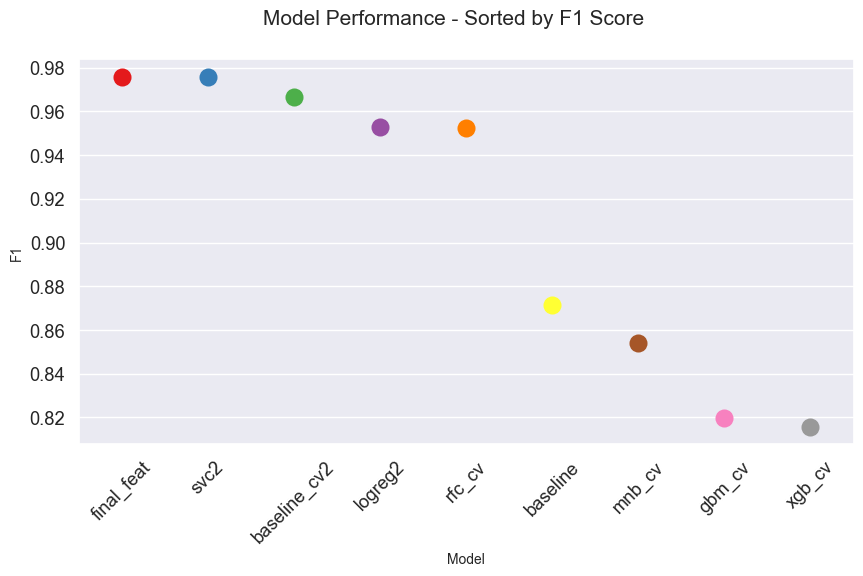

In [62]:
scores_viz_f1 = scores.sort_values(by=['f1_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="f1_test", data=scores_viz_f1, size=13, hue="index", palette="Set1")
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("F1", fontsize=10)
fig.suptitle("Model Performance - Sorted by F1 Score", fontsize=15)

#### Model comparison (Accuracy)

Text(0.5, 0.98, 'Model Performance - Sorted by Accuracy')

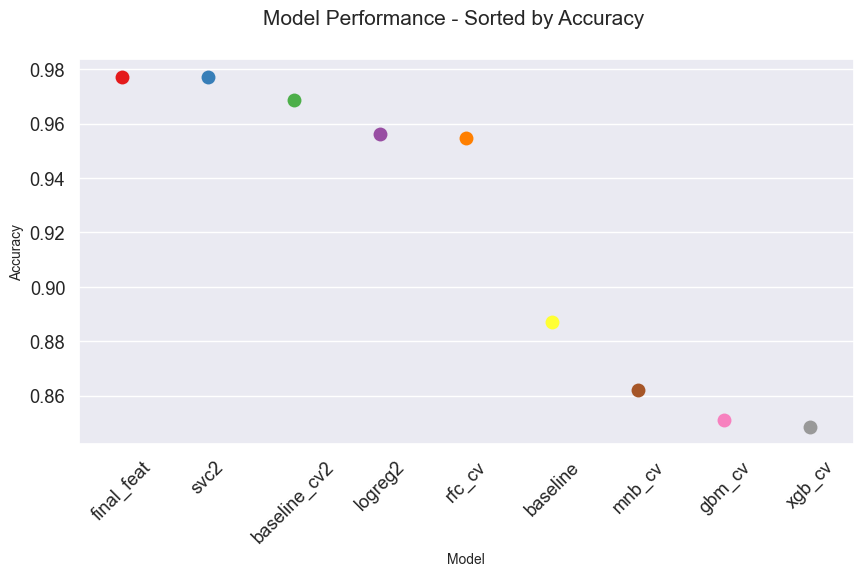

In [63]:
scores_viz_ac = scores.sort_values(by=['accuracy_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="accuracy_test", data=scores_viz_ac, size=10, hue="index", palette="Set1")
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("Accuracy", fontsize=10)
fig.suptitle("Model Performance - Sorted by Accuracy", fontsize=15)